In [14]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import math
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn

key = jax.random.PRNGKey(1)

# Masked soft attention

In [2]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = jnp.arange((maxlen), dtype=jnp.float32)[None, :] < valid_len[:, None]
    X = X.at[~mask].set(value)
    return X


def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = jnp.repeat(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.softmax(X.reshape(shape), axis=-1)

Example. Batch size 2, feature size 2, sequence length 4.
The valid lengths are 2,3. So the output has size (2,2,4),
but the length dimension is full of 0s in the invalid locations.

In [3]:
Y = masked_softmax(jax.random.uniform(key, (2, 2, 4)), jnp.array([2, 3]))
print(Y)

[[[0.47623783 0.5237622  0.         0.        ]
  [0.58380586 0.4161941  0.         0.        ]]

 [[0.3171268  0.4089036  0.27396962 0.        ]
  [0.33632544 0.32704628 0.33662832 0.        ]]]


Example. Batch size 2, feature size 2, sequence length 4.
The valid lengths are (1,3) for batch 1, and (2,4) for batch 2.

In [4]:
Y = masked_softmax(jax.random.uniform(key, (2, 2, 4)), jnp.array([[1, 3], [2, 4]]))
print(Y)

[[[1.         0.         0.         0.        ]
  [0.3567257  0.25430906 0.3889652  0.        ]]

 [[0.43679553 0.5632045  0.         0.        ]
  [0.25806358 0.25094366 0.25829598 0.23269676]]]


# Additive attention

$$
\alpha(q,k) = w_v^T \tanh(W_q q  + w_k k)
$$



In [5]:
class AdditiveAttention(nn.Module):
    """
    Additive (Bahdanau) attention mechanism.

    Attributes
    ----------
    num_hiddens : int
        Dimension of the hidden space for computing attention scores.
    dropout : float
        Dropout probability applied to attention weights.

    Call Arguments
    --------------
    queries : jnp.ndarray, shape (batch_size, num_queries, query_dim)
        Query vectors (e.g., decoder hidden states).
    keys : jnp.ndarray, shape (batch_size, num_kv_pairs, key_dim)
        Key vectors (e.g., encoder outputs).
    values : jnp.ndarray, shape (batch_size, num_kv_pairs, value_dim)
        Value vectors to be aggregated.
    valid_lens : jnp.ndarray or None
        1D or 2D lengths to mask out padding positions in keys/values.
    deterministic : bool
        If True, disable dropout (e.g., during evaluation).

    Returns
    -------
    output : jnp.ndarray, shape (batch_size, num_queries, value_dim)
        Weighted sum of values according to attention weights.
    attention_weights : jnp.ndarray, shape (batch_size, num_queries, num_kv_pairs)
        Normalized attention weights.
    """
    num_hiddens: int
    dropout: float

    @nn.compact
    def __call__(self, queries, keys, values, valid_lens=None, deterministic=True):
        # Project queries and keys into a common hidden space
        # Remove bias for efficiency; shapes:
        # - queries -> (batch_size, num_queries, num_hiddens)
        # - keys    -> (batch_size, num_kv_pairs, num_hiddens)
        proj_queries = nn.Dense(self.num_hiddens, use_bias=False)(queries)
        proj_keys    = nn.Dense(self.num_hiddens, use_bias=False)(keys)

        # Combine queries and keys via broadcasting to compute pairwise sums
        # results in shape (batch_size, num_queries, num_kv_pairs, num_hiddens)
        features = proj_queries[:, :, None, :] + proj_keys[:, None, :, :]
        # Apply nonlinearity to interaction features
        features = nn.tanh(features)

        # Compute raw attention scores:
        # - Dense unit output shape: (..., 1);
        # - remove last dim to get scores shape (batch_size, num_queries, num_kv_pairs)
        scores = nn.Dense(1, use_bias=False)(features).squeeze(-1)

        # Mask out invalid positions before softmax (padding in sequences)
        # masked_softmax replaces masked positions with -inf prior to softmax
        attention_weights = masked_softmax(scores, valid_lens)

        # Optionally apply dropout to attention weights
        dropped = nn.Dropout(rate=self.dropout, deterministic=deterministic)(attention_weights)

        # Compute weighted sum of values according to attention weights
        # Matmul over the key-value axis: (batch_size, num_queries, num_kv_pairs) @ (batch_size, num_kv_pairs, value_dim)
        output = dropped @ values
        return output, attention_weights

In [6]:
# Create random key for JAX operations
y_key = jax.random.PRNGKey(42)

# Batch of 2, 1 query per batch with dimension 20
queries = jax.random.normal(y_key, (2, 1, 20))  # shape: (batch_size=2, num_queries=1, query_dim=20)
# Batch of 2, 10 keys per batch with dimension 2, all ones for simplicity
keys = jnp.ones((2, 10, 2))                     # shape: (2, 10, key_dim=2)
# Create values: a sequence of 10 vectors of dim 4, repeated for both batches
values = jnp.arange(40, dtype=jnp.float32).reshape(1, 10, 4).repeat(2, axis=0)
print("Values shape:", values.shape)  # -> (2, 10, 4)

# valid_lens specifies how many key-value pairs are valid per example (for masking)
valid_lens = jnp.array([2, 6])  # First example uses first 2 kv pairs; second uses first 6

# Instantiate the attention module
attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
# Initialize parameters (variables) for the module
variables = attention.init(y_key, queries, keys, values, valid_lens, deterministic=True)
# Apply the module to get output and attention weights
output, attention_weights = attention.apply(
    variables, queries, keys, values, valid_lens, deterministic=True
)
print("Output shape:", output.shape)                # -> (2, 1, value_dim=4)
print("Output:", output)                            # Weighted sum of values
print("Attention weights shape:", attention_weights.shape)  # -> (2, 1, 10)
print("Attention weights:", attention_weights)      # Mostly zeros outside valid_lens ranges

Values shape: (2, 10, 4)
Output shape: (2, 1, 4)
Output: [[[ 2.        3.        4.        5.      ]]

 [[10.       11.       12.000001 13.      ]]]
Attention weights shape: (2, 1, 10)
Attention weights: [[[0.5        0.5        0.         0.         0.         0.
   0.         0.         0.         0.        ]]

 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
   0.         0.         0.         0.        ]]]


In [15]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
    """
    Display a grid of heatmaps for a batch of matrices.

    Parameters
    ----------
    matrices : array_like, shape (n_rows, n_cols, height, width)
        Stack of 2D arrays to visualize as heatmaps.
    xlabel : str
        Label for the x-axis on the bottom row of plots.
    ylabel : str
        Label for the y-axis on the first column of plots.
    titles : list of str, optional
        Column titles for each set of heatmaps; length must equal n_cols.
    figsize : tuple of float, default (2.5, 2.5)
        Size (width, height) in inches for each individual subplot.
    cmap : str or Colormap, default 'Reds'
        Colormap used to render heatmap intensities.

    Notes
    -----
    - Uses shared x- and y-axes for consistent scaling across subplots.
    - Adds a single colorbar for the entire grid.

    Example
    -------
    >>> # Create a 2x2 grid of random 4x4 heatmaps
    >>> mats = np.random.rand(2, 2, 4, 4)
    >>> show_heatmaps(mats, 'Key', 'Query', titles=['Head1', 'Head2'])
    """
    # Render SVG format in notebooks
    set_matplotlib_formats("svg")

    # Determine grid dimensions
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    # Set up subplots with shared axes
    fig, axes = plt.subplots(
        num_rows,
        num_cols,
        figsize=(figsize[0] * num_cols, figsize[1] * num_rows),
        sharex=True,
        sharey=True,
        squeeze=False
    )

    # Plot each matrix in its respective subplot
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix, cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

    # Add a unified colorbar
    fig.colorbar(pcm, ax=axes, shrink=0.6)

Before training, all keys in our toy example are identical (since we initialized them to ones and used the same projection for every position), so the additive‐attention scores are the same for each valid key. When we apply the mask—with valid_lens = [2, 6]—only the first two keys in the first batch and the first six in the second remain “in play,” while the rest are effectively set to –∞ before softmax.

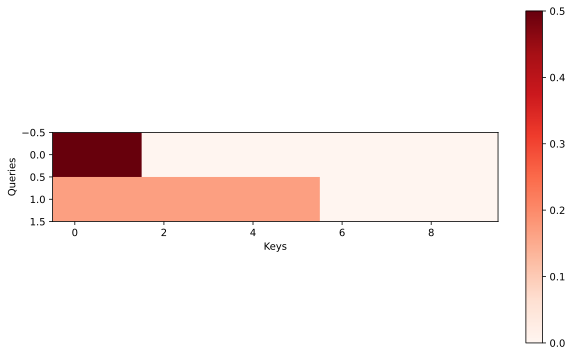

In [17]:
show_heatmaps(attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries", figsize=(10,10))

# Dot-product attention


$$
A = \text{softmax}(Q K^T/\sqrt{d}) V
$$


In [18]:
class DotProductAttention(nn.Module):
    """
    Scaled dot-product attention mechanism (Vaswani et al., 2017).

    Attributes
    ----------
    dropout : float
        Dropout probability applied to attention weights.

    Call Arguments
    --------------
    queries : jnp.ndarray, shape (batch_size, num_queries, d)
        Query vectors (e.g., decoder hidden states).
    keys : jnp.ndarray, shape (batch_size, num_kv_pairs, d)
        Key vectors (e.g., encoder outputs).
    values : jnp.ndarray, shape (batch_size, num_kv_pairs, value_dim)
        Value vectors to aggregate.
    valid_lens : None or jnp.ndarray, shape (batch_size,) or (batch_size, num_queries)
        Lengths to mask out padding positions in keys/values before softmax.
    deterministic : bool, default False
        If True, disables dropout (e.g., during evaluation).

    Returns
    -------
    output : jnp.ndarray, shape (batch_size, num_queries, value_dim)
        Aggregated values weighted by attention.
    attention_weights : jnp.ndarray, shape (batch_size, num_queries, num_kv_pairs)
        Softmax-normalized attention scores.
    """
    dropout: float

    @nn.compact
    def __call__(self, queries, keys, values, valid_lens=None, deterministic=False):
        # Determine the dimension of queries/keys
        d = queries.shape[-1]

        # Compute scaled dot-product scores:
        # scores[i, j, k] = (query[i, j] · key[i, k]) / sqrt(d)
        scores = queries @ keys.swapaxes(1, 2) / math.sqrt(d)

        # Apply mask and softmax to obtain attention weights
        attention_weights = masked_softmax(scores, valid_lens)

        # Apply dropout to attention weights during training
        dropped = nn.Dropout(rate=self.dropout, deterministic=deterministic)(attention_weights)

        # Weighted sum of values using the attention weights
        # output shape: (batch_size, num_queries, value_dim)
        output = dropped @ values

        return output, attention_weights

In [19]:
# batch size 2. 1 query of dim 2, 10 keys of  dim 2.
queries = jax.random.normal(key, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
variables = attention.init(key, queries, keys, values, valid_lens, deterministic=True)
A, attention_weights = attention.apply(variables, queries, keys, values, valid_lens, deterministic=True)
print(A)

[[[ 2.        3.        4.        5.      ]]

 [[10.       11.       12.000001 13.      ]]]


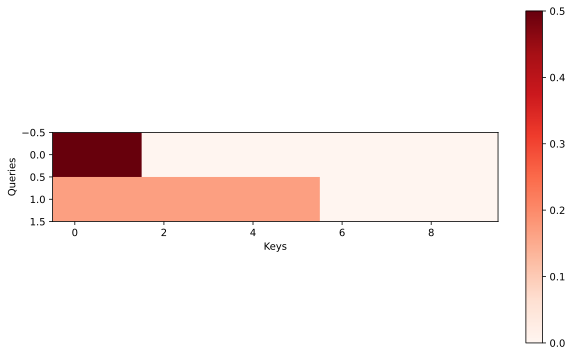

In [21]:
show_heatmaps(attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries", figsize=(10,10))